# Benchmark: Circuit simulation and expectation values

## Circuit simulation

In [1]:
from time import time
import copy
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from qiskit import Aer, execute
from qiskit.quantum_info import Statevector
from qiskit.aqua.operators import PauliExpectation, AerPauliExpectation
from qiskit.circuit.library import ZZFeatureMap, ExcitationPreserving, RealAmplitudes

AER_STATEVECTOR = Aer.get_backend('statevector_simulator')
AER_QASM = Aer.get_backend('qasm_simulator')
LABELS = ['Aer statevector', 'Aer shots', 'Aer snapshot', 'QI statevector']

In [2]:
def benchmark_circuit(n, mode='zz'):
    if mode == 'zz':
        circ = ZZFeatureMap(n, reps=10)
    elif mode == 'swaprz':
        circ = ExcitationPreserving(n, reps=10)
    else:
        circ = RealAmplitudes(n, reps=10)
    return circ.assign_parameters(np.random.random(circ.num_parameters))


def aer_statevector(circuit):
    t0 = time()
    result = execute(circuit, AER_STATEVECTOR).result().get_statevector()
    return result, time() - t0


def aer_shots(circuit):
    t0 = time()
    result = execute(circuit, AER_STATEVECTOR).result().get_counts()
    return result, time() - t0


def qi_statevector(circuit):
    t0 = time()
    sv = Statevector.from_label('0' * circuit.num_qubits).evolve(circuit)
    return sv, time() - t0


def aer_snapshot(circuit):
    t0 = time()
    sv = execute(circuit, AER_QASM).result().data(0)['snapshots']['statevector']['final']
    return sv, time() - t0


def run(nruns, circuits):
    funs = [aer_statevector, aer_shots, aer_snapshot, qi_statevector]
    labels = LABELS
    means = {label: [] for label in labels}
    stds = {label: [] for label in labels}

    for circuit_ in circuits:
        for fun, label in zip(funs, labels):
            circuit = copy.deepcopy(circuit_)
            if label == 'Aer shots':
                circuit.measure_all()
            elif label == 'Aer snapshot':
                circuit.snapshot('final')
            runtimes = []
            for _ in range(nruns):
                _, time = fun(circuit)
                runtimes.append(time)
            mean = sum(runtimes) / nruns
            std = sum((time - mean)**2 for time in runtimes) / (nruns - 1)
            print(label, 'mean', mean, 'fastest', min(runtimes))
            means[label].append(mean)
            stds[label].append(std)
            
    return means, stds


def plot(x, means, stds, circuit_name):
    plt.figure()
    for label in LABELS:
        plt.errorbar(x, means[label], yerr=stds[label],  label=label)
    plt.title('Simulation of {} with 10 reps'.format(circuit_name))
    plt.xlabel('number of qubits')
    plt.ylabel('time [s]')
    plt.legend(loc='best')
    plt.show()

In [3]:
num_qubits = [2, 4, 6, 8, 10, 12]
nruns = 50
means_zz, stds_zz = run(nruns, [benchmark_circuit(n, 'zz') for n in num_qubits])
means_swaprz, stds_swaprz = run(nruns, [benchmark_circuit(n, 'swaprz') for n in num_qubits])
means_ry, stds_ry = run(nruns, [benchmark_circuit(n) for n in num_qubits])

Aer statevector mean 0.04555286884307861 fastest 0.041046142578125
Aer shots mean 0.05022606372833252 fastest 0.04257798194885254
Aer snapshot mean 0.03506753444671631 fastest 0.027051687240600586
QI statevector mean 0.033678655624389646 fastest 0.030265092849731445
Aer statevector mean 0.155188364982605 fastest 0.08968997001647949
Aer shots mean 0.1417253303527832 fastest 0.05586695671081543
Aer snapshot mean 0.07220908164978028 fastest 0.03692007064819336
QI statevector mean 0.07265693187713623 fastest 0.04366612434387207
Aer statevector mean 0.12310535430908204 fastest 0.07602190971374512
Aer shots mean 0.13385824203491212 fastest 0.11483001708984375
Aer snapshot mean 0.07911744117736816 fastest 0.06816577911376953
QI statevector mean 0.10769449710845948 fastest 0.09860515594482422
Aer statevector mean 0.20727049827575683 fastest 0.12965130805969238
Aer shots mean 0.2097356700897217 fastest 0.14642000198364258
Aer snapshot mean 0.14250317096710205 fastest 0.11803436279296875
QI stat

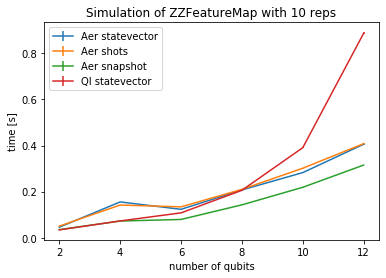

In [4]:
plot(num_qubits, means_zz, stds_zz, 'ZZFeatureMap')

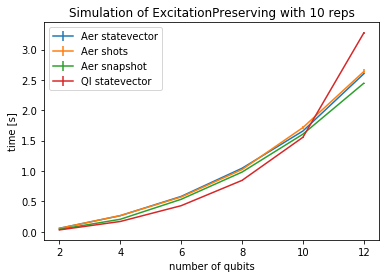

In [5]:
plot(num_qubits, means_swaprz, stds_swaprz, 'ExcitationPreserving')

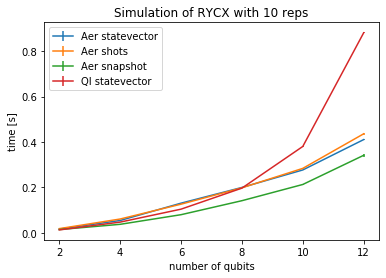

In [6]:
plot(num_qubits, means_ry, stds_ry, 'RYCX')

## Expectation values

In [18]:
from time import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['QISKIT_IN_PARALLEL'] = 'TRUE'
LABELS = ['Aer statevector', 'Aer shots', 'Aer snapshot']

from qiskit.aqua.operators import PauliExpectation, AerPauliExpectation, MatrixExpectation, StateFn, H, Y, CircuitSampler, CircuitStateFn
AER_STATEVECTOR = Aer.get_backend('statevector_simulator')
AER_QASM = Aer.get_backend('qasm_simulator')


def benchmark_expval(n, op='paulis', mode='zz'):
    ops = {'paulis': Y ^ n,
           'hadamards': H ^ n}
    circs = {'zz': ZZFeatureMap(n, reps=10),
             'swaprz': ExcitationPreserving(n, reps=10),
             'ry': RealAmplitudes(n, reps=10)}
    circ = circs[mode]
    circ.assign_parameters(np.random.random(circ.num_parameters), inplace=True)
    state = CircuitStateFn(circ)
    op = StateFn(ops[op], is_measurement=True)
    expval = op.compose(state)
    return expval


def aer_statevector(expr):
    t0 = time()
    expval = PauliExpectation().convert(expr)    
    sampler = CircuitSampler(AER_STATEVECTOR).convert(expval)
    result = sampler.eval()
    return result, time() - t0


def aer_shots(expr):
    t0 = time()
    expval = PauliExpectation().convert(expr)
    sampler = CircuitSampler(AER_QASM).convert(expval)
    result = sampler.eval()
    return result, time() - t0


def aer_snapshot(expr):
    t0 = time()    
    expval = AerPauliExpectation().convert(expr)
    sampler = CircuitSampler(AER_QASM).convert(expval)
    result = sampler.eval()
    return result, time() - t0


def run(nruns, circuits):
    funs = [aer_statevector, aer_shots, aer_snapshot]
    labels = LABELS
    means = {label: [] for label in labels}
    stds = {label: [] for label in labels}

    for expr in circuits:
        for fun, label in zip(funs, labels):
            runtimes = []
            for _ in range(nruns):
                _, time = fun(expr)
                runtimes.append(time)
            mean = sum(runtimes) / nruns
            std = sum((time - mean)**2 for time in runtimes) / (nruns - 1)
            print(label, 'mean', mean, 'fastest', min(runtimes))
            means[label].append(mean)
            stds[label].append(std)
            
    return means, stds

def plot(x, means, stds, expval_name):
    plt.figure()
    for label in LABELS:
        plt.errorbar(x, means[label], yerr=stds[label], label=label)
    plt.title('Expectation of {}'.format(expval_name))
    plt.xlabel('number of qubits')
    plt.ylabel('time [s]')
    plt.legend(loc='best')
    plt.show()

In [11]:
num_qubits = [2, 4, 6, 8, 10]
nruns = 25
means_zz_paulis, stds_zz_paulis = run(nruns, [benchmark_expval(n, 'paulis', 'zz') for n in num_qubits])
means_swaprz_paulis, stds_swaprz_paulis = run(nruns, [benchmark_expval(n, 'paulis', 'swaprz') for n in num_qubits])
means_ry_paulis, stds_ry_paulis = run(nruns, [benchmark_expval(n, 'paulis', 'ry') for n in num_qubits])

Aer statevector mean 0.017399101257324218 fastest 0.015057802200317383
Aer shots mean 0.020060615539550783 fastest 0.017447948455810547
Aer snapshot mean 0.017374248504638673 fastest 0.014934062957763672
Aer statevector mean 0.06097594261169434 fastest 0.04667520523071289
Aer shots mean 0.06184784889221191 fastest 0.0520319938659668
Aer snapshot mean 0.0627527618408203 fastest 0.04471015930175781
Aer statevector mean 0.11404788017272949 fastest 0.0943002700805664
Aer shots mean 0.15208008766174316 fastest 0.10773873329162598
Aer snapshot mean 0.1199489688873291 fastest 0.08989691734313965
Aer statevector mean 0.27532276153564456 fastest 0.17444109916687012
Aer shots mean 0.2621859836578369 fastest 0.19871091842651367
Aer snapshot mean 0.18387337684631347 fastest 0.15432214736938477
Aer statevector mean 0.34400837898254394 fastest 0.27541494369506836
Aer shots mean 0.42866891860961914 fastest 0.3144187927246094
Aer snapshot mean 0.2987189674377441 fastest 0.24632716178894043
Aer stateve

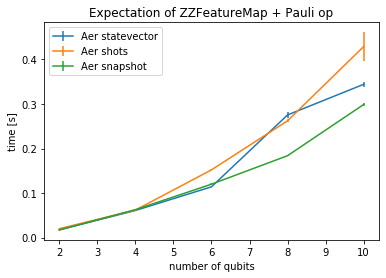

In [14]:
plot(num_qubits, means_zz_paulis, stds_zz_paulis, 'ZZFeatureMap + Pauli op')

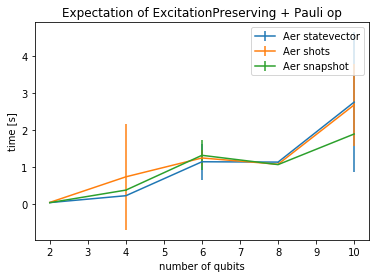

In [15]:
plot(num_qubits, means_swaprz_paulis, stds_swaprz_paulis, 'ExcitationPreserving + Pauli op')

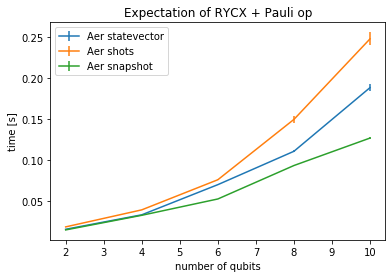

In [16]:
plot(num_qubits, means_ry_paulis, stds_ry_paulis, 'RYCX + Pauli op')

In [20]:
num_qubits = [2, 4, 6]
nruns = 25
means_zz_h, stds_zz_h = run(nruns, [benchmark_expval(n, 'hadamards', 'zz') for n in num_qubits])
means_swaprz_h, stds_swaprz_h = run(nruns, [benchmark_expval(n, 'hadamards', 'swaprz') for n in num_qubits])
means_ry_h, stds_ry_h = run(nruns, [benchmark_expval(n, 'hadamards', 'ry') for n in num_qubits])

Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer statevector mean 0.11356609344482421 fastest 0.10116767883300781


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer shots mean 0.11917715072631836 fastest 0.10786700248718262


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer snapshot mean 0.038090543746948244 fastest 0.028789043426513672


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer statevector mean 1.0052314853668214 fastest 0.8434579372406006


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer shots mean 1.3343895530700685 fastest 1.0222952365875244


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer snapshot mean 0.13599510192871095 fastest 0.10249185562133789


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer statevector mean 9.725785636901856 fastest 8.137197971343994


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer shots mean 26.763524188995362 fastest 16.35939311981201


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer snapshot mean 5.503627824783325 fastest 1.7756881713867188


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer statevector mean 0.19082485198974608 fastest 0.17458677291870117


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer shots mean 0.20305146217346193 fastest 0.17991995811462402


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer snapshot mean 0.05399482727050781 fastest 0.048655033111572266


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer statevector mean 3.6052825355529787 fastest 3.4423580169677734


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer shots mean 3.7187863063812254 fastest 3.538378953933716


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer snapshot mean 0.27637803077697753 fastest 0.2486252784729004


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer statevector mean 37.10992374420166 fastest 36.4745991230011


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer shots mean 37.95926885604858 fastest 37.179358959198


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer snapshot mean 2.325125970840454 fastest 2.1240768432617188


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer statevector mean 0.06993020057678223 fastest 0.06667089462280273


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer shots mean 0.0790937328338623 fastest 0.07484817504882812


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer snapshot mean 0.02114537239074707 fastest 0.020215988159179688


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer statevector mean 0.537970838546753 fastest 0.5007917881011963


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer shots mean 0.6281137561798096 fastest 0.5749037265777588


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer snapshot mean 0.0862034797668457 fastest 0.08463692665100098


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer statevector mean 5.059909057617188 fastest 4.863768815994263


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer shots mean 5.615420770645142 fastest 5.425950288772583


Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be expensive.
Measured Observable is not composed of only Paulis, converting to Pauli representation, which can be exp

Aer snapshot mean 1.829319248199463 fastest 1.6833980083465576


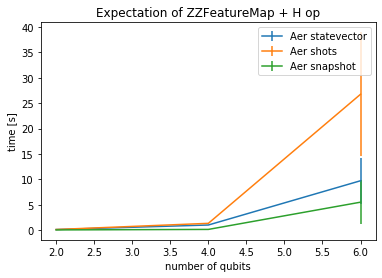

In [21]:
plot(num_qubits, means_zz_h, stds_zz_h, 'ZZFeatureMap + H op')

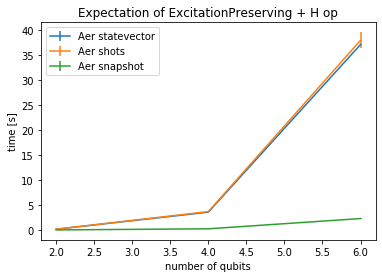

In [22]:
plot(num_qubits, means_swaprz_h, stds_swaprz_h, 'ExcitationPreserving + H op')

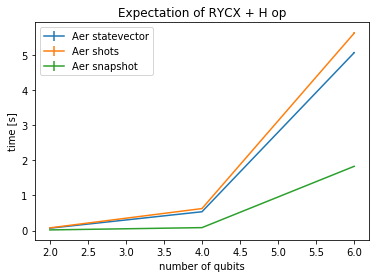

In [23]:
plot(num_qubits, means_ry_h, stds_ry_h, 'RYCX + H op')